<h1 style='text-align: center'>Gender Classification</h1>
<h3 style='text-align: center'>Using a simple perceptron </h1>

<div>
    <ol>
        <li><a href="#Introduction">Introduction</a></li>
        <li><a href="#Perceptron">Perceptron</a></li>
        <li><a href="#Data">Data</a></li>
        <li><a href="#Preprocessing">Preprocessing</a></li>
        <li><a href="#Modeling">Modeling</a></li>
        <li><a href="#Evaluation">Evaluation</a></li>
        <li><a href="#Testing">Testing</a></li>
    </ol>
</div>

<h2 id='Introduction'>Introduction</h2>
In this notebook, a gender classification model is built using a simple perceptron. The dataset contains 2307 faces images (1173 for men and 1134 for women). It will be used "Grid Search" to find the best hyperparameters for the model and finally, the model will be evaluated and tested.

<h2 id='Perceptron'>Perceptron</h2>
A perceptron is a simple model that can be used to classify data. It is a linear classifier that makes predictions based on a linear combination of the input features. The perceptron is trained using the perceptron learning algorithm, which adjusts the weights of the model to minimize the error on the training data.

<h3> Environment </h3>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import skimage
import skimage.feature
import skimage.color
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import joblib
import os
import csv
from PIL import Image
import re
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


<h2 id='Data'>Data</h2>
The dataset was obtained from the Kaggle dataset:

[Gender Classification](https://www.kaggle.com/datasets/sodiqismoilov/gender)

The dataset contains:

<table>
    <tr>
        <th>Class</th>
        <th>Total Images</th>
        <th>Percentage</th>
    </tr>
    <tr>
        <td>Man</td>
        <td>1,173</td>
        <td>50.8%</td>
    </tr>
    <tr>
        <td>Woman</td>
        <td>1,134</td>
        <td>49.2%</td>
    </tr>
    <tr>
        <td><strong>Total</strong></td>
        <td><strong>2,307</strong></td>
        <td><strong>100%</strong></td>
    </tr>
</table>

The dataset is fairly balanced with approximately 51% men and 49% women.

Key characteristics of the dataset:
- Total number of images: 2,307
- Image format: JPG
- Image dimensions: Variable (preprocessed to 128x128 for training)
- Color space: RGB
- Class distribution: Nearly balanced

In [3]:
data = pd.read_csv('Data/Data.csv')

data

,Image,Label,Size,Format
0,Data/Man/face_0.jpg,0,"(121, 170)",jpg
1,Data/Man/face_1.jpg,0,"(106, 146)",jpg
2,Data/Man/face_2.jpg,0,"(148, 248)",jpg
3,Data/Man/face_3.jpg,0,"(140, 201)",jpg
4,Data/Man/face_4.jpg,0,"(202, 263)",jpg
...,...,...,...,...
2302,Data/Woman/face_1375.jpg,1,"(124, 172)",jpg
2303,Data/Woman/face_1376.jpg,1,"(73, 96)",jpg
2304,Data/Woman/face_1377.jpg,1,"(130, 173)",jpg
2305,Data/Woman/face_1378.jpg,1,"(134, 169)",jpg


<h3> Data split </h3>

In [4]:
def extract_number(filename):
    match = re.search(r'face_(\d+)', filename)
    if match:
        return int(match.group(1))
    return 0

def create_face_dataset(data_dir="Data", test_size=0.2, random_state=42):
    X = []  
    y = []  

    man_dir = os.path.join(data_dir, "Man")
    man_images = sorted(
        [f for f in os.listdir(man_dir) if f.endswith(('.jpg', '.jpeg', '.png'))],
        key=extract_number
    )
    
    for image_name in man_images:
        image_path = os.path.join(man_dir, image_name).replace('\\', '/')
        X.append(image_path)
        y.append(0) 

    woman_dir = os.path.join(data_dir, "Woman")
    woman_images = sorted(
        [f for f in os.listdir(woman_dir) if f.endswith(('.jpg', '.jpeg', '.png'))],
        key=extract_number
    )
    
    for image_name in woman_images:
        image_path = os.path.join(woman_dir, image_name).replace('\\', '/')
        X.append(image_path)
        y.append(1) 
    
    X = np.array(X)
    y = np.array(y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state,
        stratify=y  
    )
    
    save_csv('Data/train_dataset.csv', X_train, y_train)
    save_csv('Data/test_dataset.csv', X_test, y_test)
    
    return X_train, y_train, X_test, y_test, X, y

def save_csv(filename, images, labels):
    data = []
    for img_path, label in zip(images, labels):
        with Image.open(img_path) as img:
            size = img.size
            format = img.format.lower()
        data.append([img_path, label, size, format])
    
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Image', 'Label', 'Size', 'Format'])
        csv_writer.writerows(data)

def create_distribution_table(y_train, y_test):
    train_men = sum(y_train == 0)
    train_women = sum(y_train == 1)
    test_men = sum(y_test == 0)
    test_women = sum(y_test == 1)
    
    data = {
        'Men': [train_men, test_men, train_men + test_men],
        'Women': [train_women, test_women, train_women + test_women],
        'Total': [len(y_train), len(y_test), len(y_train) + len(y_test)]
    }
    
    df = pd.DataFrame(data, index=['Train', 'Test', 'Total'])
    
    df['Men %'] = (df['Men'] / df['Total'] * 100).round(2)
    df['Women %'] = (df['Women'] / df['Total'] * 100).round(2)
    
    return df

X_train, y_train, X_test, y_test, X, y = create_face_dataset(test_size=0.2)

distribution_table = create_distribution_table(y_train, y_test)
print("\nDataset Distribution:")
print(distribution_table)


Dataset Distribution:
        Men  Women  Total  Men %  Women %
Train   938    907   1845  50.84    49.16
Test    235    227    462  50.87    49.13
Total  1173   1134   2307  50.85    49.15


Plotting 5 random images from the dataset:

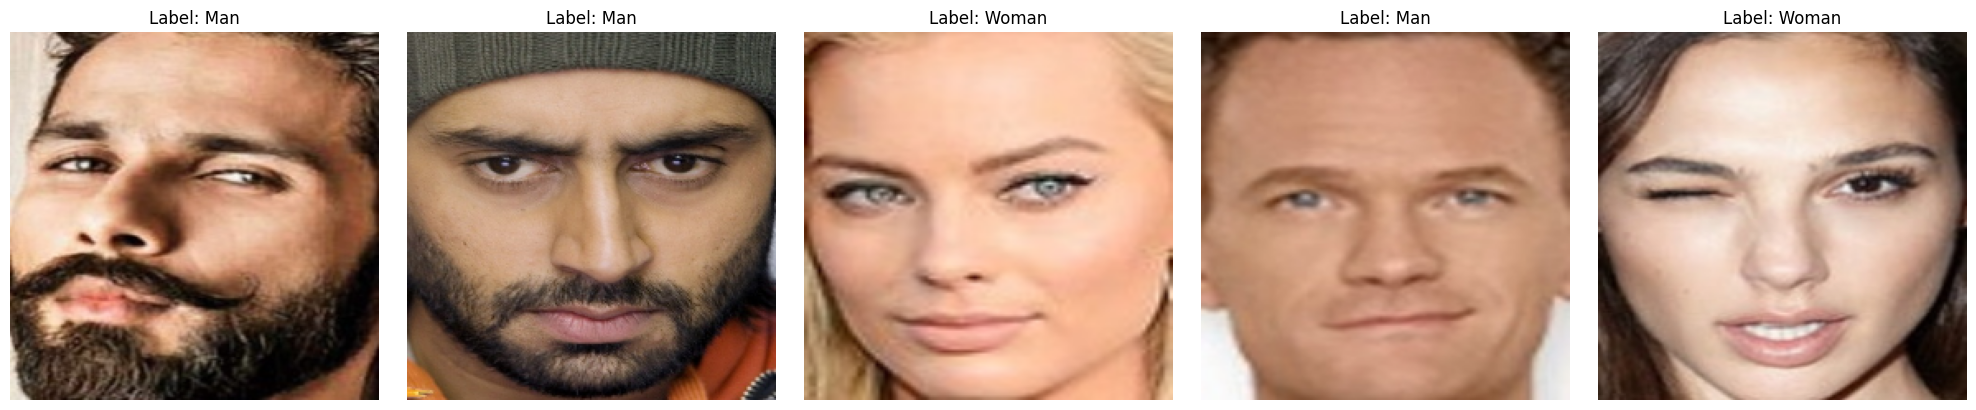

In [5]:
def plot_random_samples(X_train, y_train, n_samples=5, figsize=(20, 4)):
    indices = np.random.choice(range(len(X_train)), n_samples, replace=False)

    fig, axes = plt.subplots(1, n_samples, figsize=figsize)

    for idx, ax in enumerate(axes):
        img_path = X_train[indices[idx]]
        label = y_train[indices[idx]]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Label: {"Man" if label == 0 else "Woman"}')
    
    plt.tight_layout()
    plt.show()

plot_random_samples(X_train, y_train)

<h2 id='Preprocessing'>Preprocessing</h2>

<h4> Image Features & Preprocessing </h4>

In [6]:
class Image:
    def __init__(self, image):
        self.image = self.preprocessImage(image)
        #Basics features
        self.colorChannelsRGB = self.extractColorChannelsRGB()
        self.RGBMean = self.calculateRGBMean()
        self.RGBMode = self.calculateRGBMode()
        self.RGBVariance = self.calculateRGBVariance()
        self.RGBStandardDeviation = self.calculateRGBStandardDeviation()
        self.colorHistogram = self.calculateColorHistogram()
        #Advanced features
        self.grayLevelCooccurrenceMatrixProperties = self.calculateGrayLevelCooccurrenceMatrixProperties()
        self.histogramOfOrientedGradients = self.calculateHistogramOfOrientedGradients()
        self.peakLocalMax = self.calculatePeakLocalMax()
        self.huMoments = self.getHuMoments()
        self.edgeDensity = self.calculateEdgeDensity()
        self.imageEntropy = self.calculateImageEntropy()
        self.laplacianMeanStd = self.calculateLaplacianMeanStd()
        self.aspectRatio = self.calculateAspectRatio()
        self.circularity = self.calculateCircularity()
        #Feature vector
        self.featureVector = self.generateFeatureVector()

    def preprocessImage(self, image):
        image = cv2.resize(image, (128, 128))
        return image

    def extractColorChannelsRGB(self):
        redChannel = self.image[:,:,0]
        greenChannel = self.image[:,:,1]
        blueChannel = self.image[:,:,2]

        return [redChannel, greenChannel, blueChannel]

    def calculateRGBMean(self):
        redChannel = self.image[:,:,0]
        greenChannel = self.image[:,:,1]
        blueChannel = self.image[:,:,2]
        redMean = np.mean(redChannel)
        greenMean = np.mean(greenChannel)
        blueMean = np.mean(blueChannel)

        return [redMean, greenMean, blueMean]

    def calculateRGBMode(self):
        redChannel = self.image[:,:,0]
        greenChannel = self.image[:,:,1]
        blueChannel = self.image[:,:,2]
        redMode = skimage.exposure.histogram(redChannel)[1].argmax()
        greenMode = skimage.exposure.histogram(greenChannel)[1].argmax()
        blueMode = skimage.exposure.histogram(blueChannel)[1].argmax()

        return [redMode, greenMode, blueMode]

    def calculateRGBVariance(self):
        redChannel = self.image[:,:,0]
        greenChannel = self.image[:,:,1]
        blueChannel = self.image[:,:,2]
        redVariance = np.var(redChannel.flatten())
        greenVariance = np.var(greenChannel.flatten())
        blueVariance = np.var(blueChannel.flatten())

        return [redVariance, greenVariance, blueVariance]

    def calculateRGBStandardDeviation(self):
        redChannel = self.image[:,:,0]
        greenChannel = self.image[:,:,1]
        blueChannel = self.image[:,:,2]
        redStandardDeviation = np.std(redChannel)
        greenStandardDeviation = np.std(greenChannel)
        blueStandardDeviation = np.std(blueChannel)

        return [redStandardDeviation, greenStandardDeviation, blueStandardDeviation]

    def calculateColorHistogram(self):
        image = self.image
        bins = 256
        # Calculate the histogram for each channel
        histogram = [cv2.calcHist([image], [i], None, [bins], [0, 256]) for i in range(3)]
        # Normalize the histograms
        histogram = [cv2.normalize(hist, hist).flatten() for hist in histogram]

        return histogram

    def calculateGrayLevelCooccurrenceMatrixProperties(self):
        image_gray = skimage.color.rgb2gray(self.image)
        image_gray_u8 = (image_gray * 255).astype(np.uint8)
        glcm = skimage.feature.graycomatrix(image_gray_u8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = skimage.feature.graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = skimage.feature.graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = skimage.feature.graycoprops(glcm, 'homogeneity')[0, 0]
        energy = skimage.feature.graycoprops(glcm, 'energy')[0, 0]
        correlation = skimage.feature.graycoprops(glcm, 'correlation')[0, 0]

        return [contrast, dissimilarity, homogeneity, energy, correlation]

    def calculateHistogramOfOrientedGradients(self):
        image_gray = skimage.color.rgb2gray(self.image)

        return skimage.feature.hog(image_gray, pixels_per_cell=(16, 16), cells_per_block=(1, 1), orientations=9, visualize=False)

    def calculatePeakLocalMax(self):
        image_gray = skimage.color.rgb2gray(self.image)

        return skimage.feature.peak_local_max(image_gray, min_distance=1, threshold_abs=0.1, num_peaks=10)

    def getHuMoments(self):
        image_gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        image_gray = cv2.GaussianBlur(image_gray, (5, 5), 0)
        _, image_gray = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        moments = cv2.moments(image_gray)
        huMoments = cv2.HuMoments(moments)

        return huMoments

    def calculateEdgeDensity(self):
        edges = cv2.Canny(self.image, 100, 200)
        edge_density = np.sum(edges > 0) / (self.image.shape[0] * self.image.shape[1])
        return edge_density

    def calculateImageEntropy(self):
        gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        hist, _ = np.histogram(gray_image, bins=256, range=(0, 256), density=True)
        hist = hist[hist > 0]
        entropy = -np.sum(hist * np.log2(hist))
        return entropy

    def calculateLaplacianMeanStd(self):
        gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
        return [np.mean(laplacian), np.std(laplacian)]

    def calculateAspectRatio(self):
        h, w, _ = self.image.shape
        return w / h

    def calculateCircularity(self):
        gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            if perimeter > 0:
                circularity = (4 * np.pi * area) / (perimeter ** 2)
                return circularity
        return 0.0

    def generateFeatureVector(self):
        featureVector = np.array([])

        featureVector = np.append(featureVector, self.RGBMean)
        featureVector = np.append(featureVector, self.RGBMode)
        featureVector = np.append(featureVector, self.RGBVariance)
        featureVector = np.append(featureVector, self.RGBStandardDeviation)
        featureVector = np.append(featureVector, np.concatenate([ histogram.flatten() for histogram in self.colorHistogram ]))
        featureVector = np.append(featureVector, self.grayLevelCooccurrenceMatrixProperties)
        featureVector = np.append(featureVector, self.histogramOfOrientedGradients)
        featureVector = np.append(featureVector, self.peakLocalMax)
        featureVector = np.append(featureVector, self.huMoments)
        featureVector = np.append(featureVector, self.edgeDensity)
        featureVector = np.append(featureVector, self.imageEntropy)
        featureVector = np.append(featureVector, self.laplacianMeanStd)
        featureVector = np.append(featureVector, self.aspectRatio)
        featureVector = np.append(featureVector, self.circularity)

        return featureVector

<h4> Feature Extraction </h4>

In [7]:
def prepare_features(image_paths, labels):
    features = []
    for img_path in tqdm(image_paths, desc="Processing images"):
        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Error loading image: {img_path}")
                continue
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            img_processor = Image(image)
            features.append(img_processor.featureVector)
            
        except Exception as e:
            print(f"Error processing image {img_path}: {str(e)}")
            continue
    
    return np.array(features), np.array(labels)

def prepare_tensors(X_train_features, y_train, X_test_features, y_test):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    try:
        with tqdm(total=4, desc="Tensor conversion") as pbar:
            X_train_tensor = torch.FloatTensor(X_train_features).to(device)
            pbar.update(1)
            
            y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1)).to(device)
            pbar.update(1)
            
            X_test_tensor = torch.FloatTensor(X_test_features).to(device)
            pbar.update(1)
            
            y_test_tensor = torch.FloatTensor(y_test.reshape(-1, 1)).to(device)
            pbar.update(1)
    
        return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor
        
    except RuntimeError as e:
        print(f"Error during tensor conversion: {e}")
        print("\nFalling back to CPU...")
        
        device = torch.device("cpu")
        with tqdm(total=4, desc="Tensor conversion (CPU)") as pbar:
            X_train_tensor = torch.FloatTensor(X_train_features)
            pbar.update(1)
            
            y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1))
            pbar.update(1)
            
            X_test_tensor = torch.FloatTensor(X_test_features)
            pbar.update(1)
            
            y_test_tensor = torch.FloatTensor(y_test.reshape(-1, 1))
            pbar.update(1)
        
        return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor


X_train_features, y_train = prepare_features(X_train, y_train)
X_test_features, y_test = prepare_features(X_test, y_test)

with tqdm(total=2, desc="Scaling") as pbar:
    scaler = StandardScaler()
    X_train_features = scaler.fit_transform(X_train_features)
    pbar.update(1)
    X_test_features = scaler.transform(X_test_features)
    pbar.update(1)

X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = prepare_tensors(
    X_train_features,  
    y_train,
    X_test_features,  
    y_test
)

print("\nTensor shapes:")
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")

print("\nTensor devices:")
print(f"X_train_tensor device: {X_train_tensor.device}")
print(f"y_train_tensor device: {y_train_tensor.device}")
print(f"X_test_tensor device: {X_test_tensor.device}")
print(f"y_test_tensor device: {y_test_tensor.device}")

Scaling: 100%|██████████| 2/2 [00:00<00:00, 71.43it/s]


Using device: cuda


Tensor conversion: 100%|██████████| 4/4 [00:00<00:00, 47.33it/s]


Tensor shapes:
X_train_tensor shape: torch.Size([1845, 1394])
y_train_tensor shape: torch.Size([1845, 1])
X_test_tensor shape: torch.Size([462, 1394])
y_test_tensor shape: torch.Size([462, 1])

Tensor devices:
X_train_tensor device: cuda:0
y_train_tensor device: cuda:0
X_test_tensor device: cuda:0
y_test_tensor device: cuda:0


<h2 id='Modeling'>Modeling</h2>

<h4> Perceptron </h4>

In [8]:
class Perceptron(nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)
        self.history = {'loss': [], 'accuracy': []}

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

    def fit(self, X_train, y_train, max_iter, tol, criterion, optimizer):
        self.train()
        prev_loss = float('inf')

        self.history = {'loss': [], 'accuracy': []}

        for epoch in range(max_iter):
            optimizer.zero_grad()
            outputs = self(X_train)
            loss = criterion(outputs, y_train)
            
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                predictions = (outputs >= 0.5).float()
                accuracy = (predictions == y_train).float().mean()

                self.history['loss'].append(loss.item())
                self.history['accuracy'].append(accuracy.item())

            if abs(prev_loss - loss.item()) < tol:
                break
            prev_loss = loss.item()

    def evaluate(self, X_test):
        self.eval()
        with torch.no_grad():
            outputs = self(X_test)
            predictions = (outputs >= 0.5).float()
        return predictions.cpu().numpy()

    def predict(self, X_new):
        self.eval()
        with torch.no_grad():
            outputs = self(X_new)
            predictions = (outputs >= 0.5).float()
        return predictions.cpu().numpy()

<h2 id='Training'>Training</h2>
Grid search to find the best hyperparameters for for the Perceptron model.

In [9]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],  # Learning rate
    'max_iter': [100, 1000, 10000],  # Max iterations
    'tol': [1e-3, 1e-4, 1e-5]        # Stopping tolerance
}

total_combinations = len(param_grid['alpha']) * len(param_grid['max_iter']) * len(param_grid['tol'])

grid = ParameterGrid(param_grid)
best_model = None
best_params = None
best_test_accuracy = 0
results = []

pbar = tqdm(total=total_combinations, desc="Grid Search Progress")

for params in grid:
    try:
        model = Perceptron(input_size=X_train_features.shape[1]).to("cuda")
        criterion = nn.BCELoss()
        optimizer = optim.SGD(model.parameters(), lr=params['alpha'])

        model.fit(X_train_tensor, y_train_tensor, 
                 params['max_iter'], 
                 params['tol'], 
                 criterion, 
                 optimizer)

        train_predictions = model.evaluate(X_train_tensor)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_precision = precision_score(y_train, train_predictions)
        train_recall = recall_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions)

        test_predictions = model.evaluate(X_test_tensor)
        test_accuracy = accuracy_score(y_test, test_predictions)
        test_precision = precision_score(y_test, test_predictions)
        test_recall = recall_score(y_test, test_predictions)
        test_f1 = f1_score(y_test, test_predictions)

        results.append({
            'alpha': params['alpha'],
            'max_iter': params['max_iter'],
            'tol': params['tol'],
            'train_accuracy': train_accuracy,
            'train_precision': train_precision,
            'train_recall': train_recall,
            'train_f1': train_f1,
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1,
            'diff_accuracy': train_accuracy - test_accuracy
        })

        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model = model
            best_params = params

    except Exception as e:
        print(f"\nError with parameters: {params}")
        print(f"Error message: {str(e)}")
    
    pbar.update(1)

pbar.close()

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('test_accuracy', ascending=False)

results_df.to_csv('Results/Perceptron/grid_search_results_perceptron.csv', index=False)

torch.save({
    'model_state_dict': best_model.state_dict(),
    'params': best_params,
    'history': best_model.history,
    'input_size': X_train_features.shape[1],
    'train_metrics': {
        'accuracy': results_df.iloc[0]['train_accuracy'],
        'precision': results_df.iloc[0]['train_precision'],
        'recall': results_df.iloc[0]['train_recall'],
        'f1': results_df.iloc[0]['train_f1']
    },
    'test_metrics': {
        'accuracy': results_df.iloc[0]['test_accuracy'],
        'precision': results_df.iloc[0]['test_precision'],
        'recall': results_df.iloc[0]['test_recall'],
        'f1': results_df.iloc[0]['test_f1']
    }
}, 'Models/best_perceptron_model.pth')

joblib.dump(scaler, 'Models/perceptron_scaler.pkl')

print("\nBest model and scaler saved successfully!")

results_df

Grid Search Progress: 100%|██████████| 27/27 [00:27<00:00,  1.00s/it]


Best model and scaler saved successfully!


,alpha,max_iter,tol,train_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_precision,test_recall,test_f1,diff_accuracy
22,0.0100,1000,0.00010,0.949593,0.956278,0.940463,0.948305,0.904762,0.917808,0.885463,0.901345,0.044832
17,0.0010,10000,0.00001,0.947967,0.957159,0.936053,0.946488,0.902597,0.925234,0.872247,0.897959,0.045370
25,0.0100,10000,0.00010,0.946883,0.955006,0.936053,0.945434,0.898268,0.916667,0.872247,0.893905,0.048615
23,0.0100,1000,0.00001,0.959350,0.966368,0.950386,0.958310,0.896104,0.916279,0.867841,0.891403,0.063246
20,0.0100,100,0.00001,0.908401,0.918367,0.893054,0.905534,0.889610,0.923077,0.845815,0.882759,0.018791
26,0.0100,10000,0.00001,0.991870,0.993363,0.990077,0.991717,0.885281,0.895455,0.867841,0.881432,0.106589
21,0.0100,1000,0.00100,0.902439,0.911665,0.887541,0.899441,0.872294,0.888889,0.845815,0.866817,0.030145
8,0.0001,10000,0.00001,0.899187,0.909194,0.883131,0.895973,0.865801,0.887324,0.832599,0.859091,0.033386
18,0.0100,100,0.00100,0.901355,0.914286,0.882029,0.897868,0.865801,0.876712,0.845815,0.860987,0.035554
14,0.0010,1000,0.00001,0.908401,0.919318,0.891951,0.905428,0.863636,0.883178,0.832599,0.857143,0.044765


<h2 id='Evaluation'>Evaluation</h2>


Best Model Performance:

Parameters:
alpha: 0.01
max_iter: 1000
tol: 0.0001

Training Metrics:
Accuracy: 0.9496
Precision: 0.9563
Recall: 0.9405
F1-Score: 0.9483

Test Metrics:
Accuracy: 0.9048
Precision: 0.9178
Recall: 0.8855
F1-Score: 0.9013


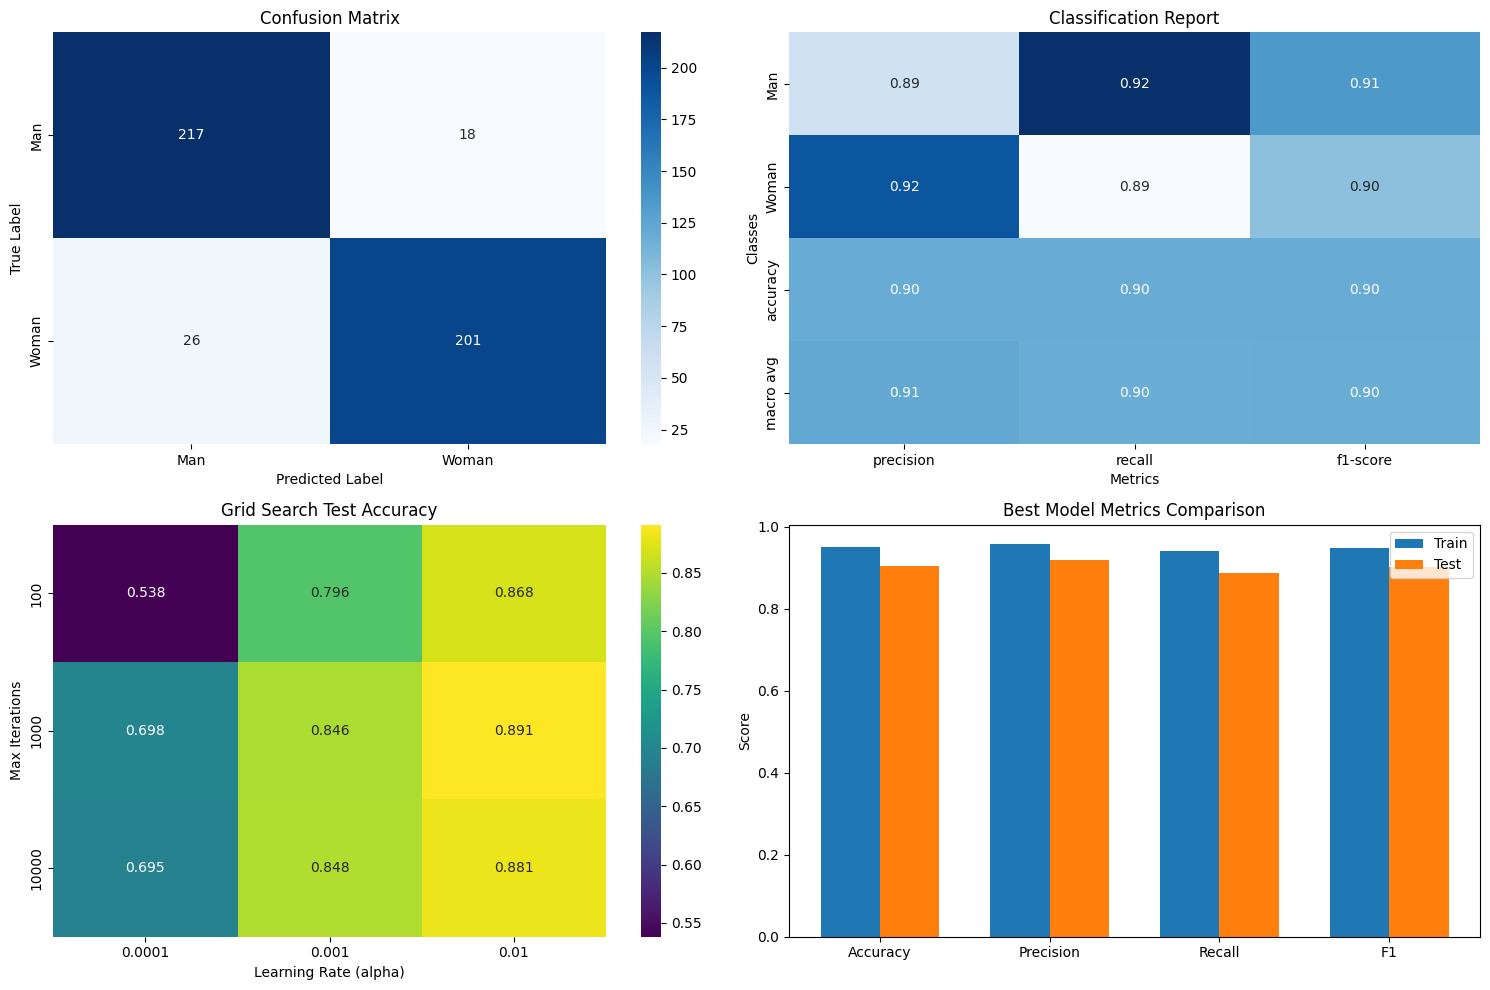

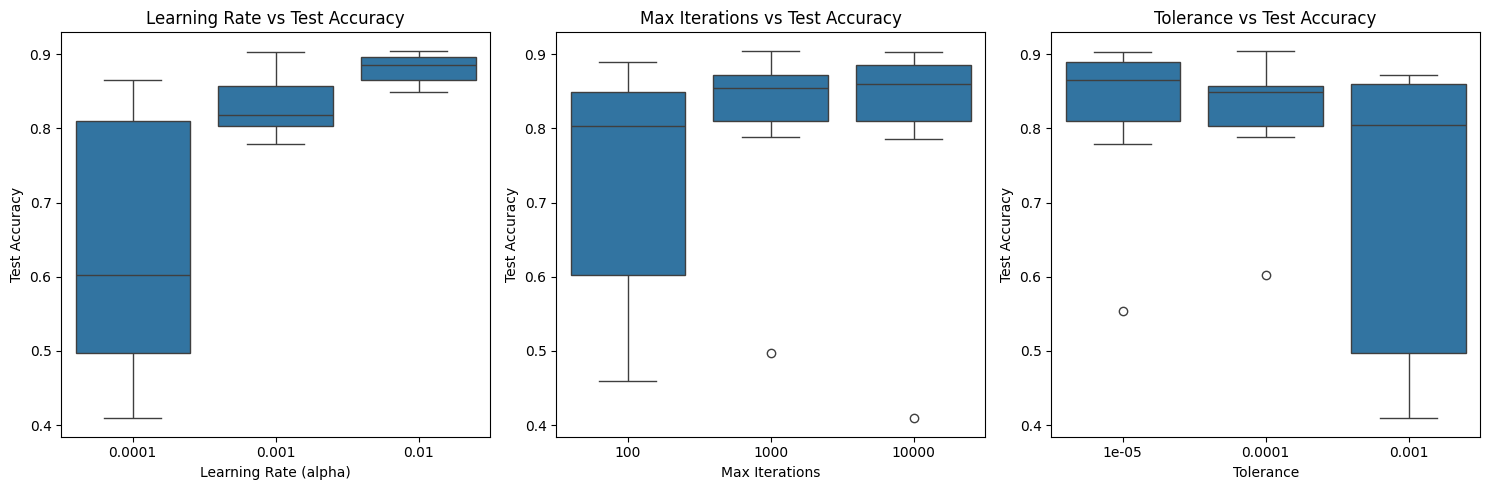

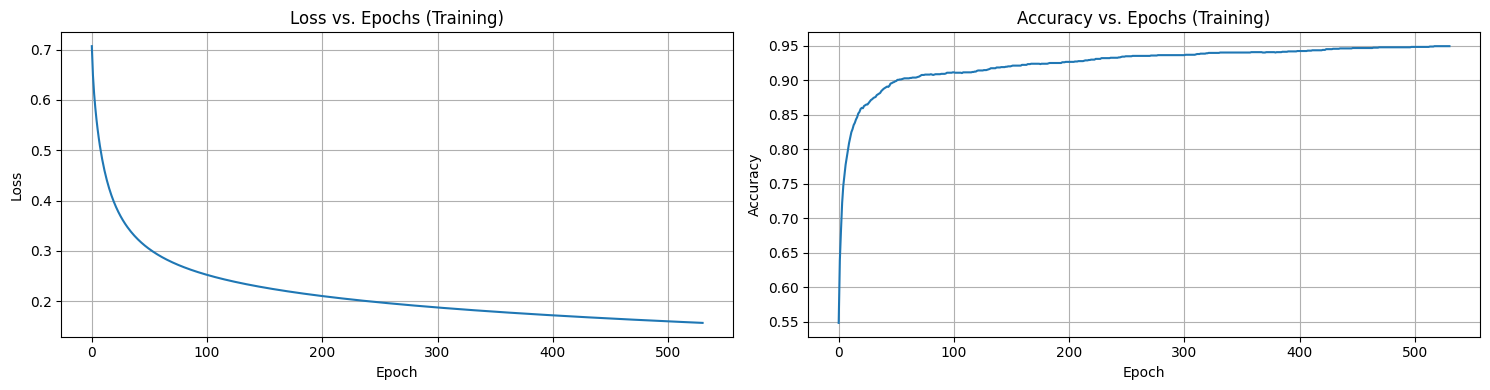

In [10]:
print("\nBest Model Performance:")
print("\nParameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

print("\nTraining Metrics:")
print(f"Accuracy: {results_df.iloc[0]['train_accuracy']:.4f}")
print(f"Precision: {results_df.iloc[0]['train_precision']:.4f}")
print(f"Recall: {results_df.iloc[0]['train_recall']:.4f}")
print(f"F1-Score: {results_df.iloc[0]['train_f1']:.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {results_df.iloc[0]['test_accuracy']:.4f}")
print(f"Precision: {results_df.iloc[0]['test_precision']:.4f}")
print(f"Recall: {results_df.iloc[0]['test_recall']:.4f}")
print(f"F1-Score: {results_df.iloc[0]['test_f1']:.4f}")

best_model.eval()
with torch.no_grad():
    y_pred = best_model.predict(X_test_tensor)

y_pred = y_pred.flatten()
y_pred = y_pred.astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['Man', 'Woman'], output_dict=True)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Man', 'Woman'], 
            yticklabels=['Man', 'Woman'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 2, 2)
class_report_df = pd.DataFrame(class_report).transpose()
sns.heatmap(class_report_df.iloc[:-1, :-1], annot=True, fmt='.2f', 
            cmap='Blues', cbar=False)
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')

plt.subplot(2, 2, 3)
heatmap_data = results_df.pivot_table(
    index='max_iter',
    columns='alpha',
    values='test_accuracy', 
    aggfunc='mean'
)
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Grid Search Test Accuracy')
plt.xlabel('Learning Rate (alpha)')
plt.ylabel('Max Iterations')

plt.subplot(2, 2, 4)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [results_df.iloc[0]['train_' + m.lower()] for m in metrics]
test_scores = [results_df.iloc[0]['test_' + m.lower()] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, train_scores, width, label='Train')
plt.bar(x + width/2, test_scores, width, label='Test')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Best Model Metrics Comparison')
plt.legend()

plt.tight_layout()
plt.savefig('Results/Perceptron/perceptron_results.png')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(x='alpha', y='test_accuracy', data=results_df, ax=axes[0])
axes[0].set_title('Learning Rate vs Test Accuracy')
axes[0].set_xlabel('Learning Rate (alpha)')
axes[0].set_ylabel('Test Accuracy')

sns.boxplot(x='max_iter', y='test_accuracy', data=results_df, ax=axes[1])
axes[1].set_title('Max Iterations vs Test Accuracy')
axes[1].set_xlabel('Max Iterations')
axes[1].set_ylabel('Test Accuracy')

sns.boxplot(x='tol', y='test_accuracy', data=results_df, ax=axes[2])
axes[2].set_title('Tolerance vs Test Accuracy')
axes[2].set_xlabel('Tolerance')
axes[2].set_ylabel('Test Accuracy')

plt.tight_layout()
plt.savefig('Results/Perceptron/hyperparameters_metrics_perceptron.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Man', 'Woman'], 
            yticklabels=['Man', 'Woman'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('Results/Perceptron/confusion_matrix_perceptron.png')
plt.close()

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(best_model.history['loss'])
plt.title('Loss vs. Epochs (Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(best_model.history['accuracy'])
plt.title('Accuracy vs. Epochs (Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.savefig('Results/Perceptron/loss_accuracy_perceptron.png')
plt.show()

with open('Results/Perceptron/perceptron_results.txt', 'w') as f:
    f.write("Best Model Performance\n\n")
    f.write("Parameters:\n")
    for param, value in best_params.items():
        f.write(f"{param}: {value}\n")
    
    f.write("\nTraining Metrics:\n")
    f.write(f"Accuracy: {results_df.iloc[0]['train_accuracy']:.4f}\n")
    f.write(f"Precision: {results_df.iloc[0]['train_precision']:.4f}\n")
    f.write(f"Recall: {results_df.iloc[0]['train_recall']:.4f}\n")
    f.write(f"F1-Score: {results_df.iloc[0]['train_f1']:.4f}\n")
    
    f.write("\nTest Metrics:\n")
    f.write(f"Accuracy: {results_df.iloc[0]['test_accuracy']:.4f}\n")
    f.write(f"Precision: {results_df.iloc[0]['test_precision']:.4f}\n")
    f.write(f"Recall: {results_df.iloc[0]['test_recall']:.4f}\n")
    f.write(f"F1-Score: {results_df.iloc[0]['test_f1']:.4f}\n")

<h2 id='Testing'>Testing</h2>
Testing the best model on the test dataset:

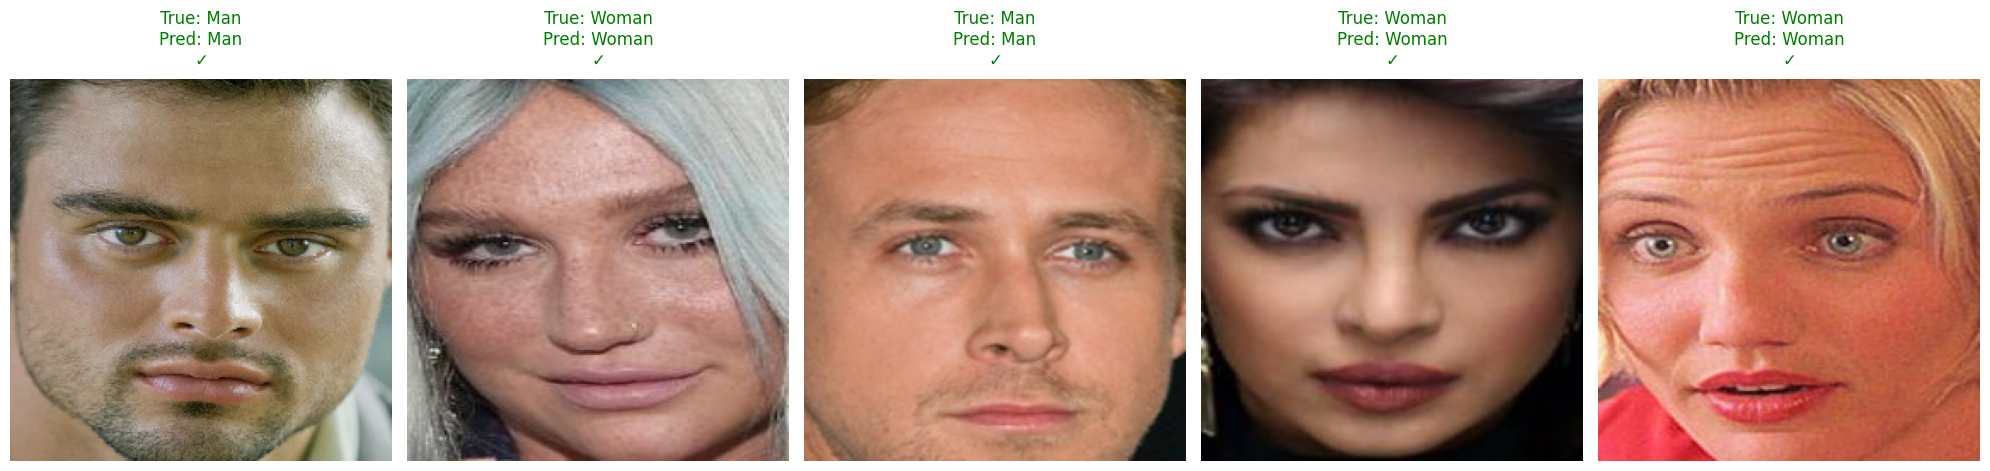

In [11]:
random_indices = np.random.choice(range(len(X_test)), 5, replace=False)
fig, axes = plt.subplots(1, 5, figsize=(20, 20))

for i, ax in enumerate(axes):
    try:
        idx = random_indices[i]
        img_path = X_test[idx]
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error loading image: {img_path}")
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        image = Image(img)
        feature_vector = np.array(image.featureVector).reshape(1, -1)

        feature_vector_scaled = scaler.transform(feature_vector)
        feature_vector_tensor = torch.tensor(feature_vector_scaled, dtype=torch.float32).to(device)

        predicted_label = best_model.predict(feature_vector_tensor).item()
        true_label = y_test[idx]

        is_correct = int(predicted_label) == true_label
        color = 'green' if is_correct else 'red'
        
        ax.imshow(cv2.resize(img, (224, 224)))
        ax.axis('off')

        title = f"True: {'Man' if true_label == 0 else 'Woman'}\n"
        title += f"Pred: {'Man' if int(predicted_label) == 0 else 'Woman'}\n"
        title += f"{'✓' if is_correct else '✗'}"
        
        ax.set_title(title, color=color, fontsize=12, pad=10)
        
    except Exception as e:
        print(f"Error processing image at index {idx}: {str(e)}")
        continue

plt.tight_layout()
plt.show()